In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno

from scipy.stats import shapiro

from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import matthews_corrcoef
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.dummy import DummyClassifier
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
import warnings
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
import shap
import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline


import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [3]:
%load_ext autoreload
%autoreload 2
from help_tool import help_tool

In [4]:
stroke_data = help_tool.csv_download(
    r"C:\Users\Gintare\Desktop\Study\Module3\Sprint2\Code\archive\healthcare-dataset-stroke-data.csv").drop(columns=['Id'])

stroke_data['Age'] = stroke_data['Age'].astype(int)


# Dropping 'Gender' = 'Other'
stroke_data = stroke_data[
    (stroke_data['Age'] >= 18)
    & (stroke_data['Gender'] != 'Other')
    & (stroke_data['Work_type'] != 'Never_worked')
]

# Converting Binary answer features to 1/0
stroke_data = help_tool.dummy_columns(stroke_data, ['Gender', 'Ever_married', 'Residence_type']).drop(columns=['Gender_Male', 'Residence_type_Rural']).rename(columns={'Residence_type_Urban': 'Residence_Urban'})


# Scalling 0 to 1, as KNN is sensitive to neighbor distince
stroke_data['Age'] = stroke_data['Age']/100
stroke_data['Avg_glucose_level'] = stroke_data['Avg_glucose_level']/300
stroke_data['Bmi'] = stroke_data['Bmi']/100


# Ordinal encoding for Smoking_status
stroke_data['Smoking_status'].replace(
    {
        'Unknown': np.nan,
        'never smoked': 0,
        'formerly smoked': -1,
        'smokes': 1
    },
    inplace=True)

# Imputation with extension
stroke_data['Smoking_status_was_missing'] = stroke_data['Smoking_status'].isnull().astype(int)
stroke_data['Bmi_was_missing'] = stroke_data['Bmi'].isnull().astype(int)

In [5]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

In [6]:
# Removing non-scalled features
def_imputation = stroke_data_dummies.drop(['Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)


# KNNImputer for NaN values
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(def_imputation)
imputed_features = imputer.transform(def_imputation)
imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)

In [7]:
# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi']=imputed_df['Bmi']
stroke_data['Smoking_status']=imputed_df['Smoking_status'].round().astype(int)

In [8]:
stroke_data.isna().sum()

Age                           0
Hypertension                  0
Heart_disease                 0
Work_type                     0
Avg_glucose_level             0
Bmi                           0
Smoking_status                0
Stroke                        0
Gender_Female                 0
Ever_married                  0
Residence_Urban               0
Smoking_status_was_missing    0
Bmi_was_missing               0
dtype: int64

In [9]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

In [10]:
help_tool.first_look(stroke_data_dummies)

Column data types:
Age                           float64
Hypertension                    int64
Heart_disease                   int64
Avg_glucose_level             float64
Bmi                           float64
Smoking_status                  int32
Stroke                          int64
Gender_Female                   int32
Ever_married                    int32
Residence_Urban                 int32
Smoking_status_was_missing      int32
Bmi_was_missing                 int32
Work_type_Govt_job              int32
Work_type_Private               int32
Work_type_Self-employed         int32
dtype: object

Dataset has 4248 observations and 15 features
Columns with NULL values: []
Dataset has 0 duplicates


Data is ready for modeling, no missing values or duplicates

## Splitting Data 
Splitting data into 3 subsets:
* train (training) 
* validation - model tuning vs unseen data
* test - picking out the best model, where performance is checked on unseen data

In [11]:
X = stroke_data_dummies.drop('Stroke', axis=1)
y = stroke_data_dummies['Stroke']

(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.4, random_state=42)

(X_validation, X_test, y_validation, y_test) = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42, stratify=y_vt)

# Models
## Baseline model

In [12]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)

help_tool.model_selection_recall(dummy, X_train, y_train, X_validation, y_validation)

Train Recall: 5.31%
Validation Recall: 5.19%
ROC AUC: 0.50


### Hyperparameter tuning

In [13]:
gaussion = GaussianNB()
gaussion.fit(X_train, y_train)

help_tool.model_selection_recall(gaussion, X_train, y_train, X_validation, y_validation)

Train Recall: 17.55%
Validation Recall: 25.71%
ROC AUC: 0.81


In [14]:
models = {
    'svm': (SVC(kernel='rbf'), {'svm__C': reciprocal(0.1, 100), 'svm__gamma': reciprocal(0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'logisticr__C': reciprocal(0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'dtree__max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'rforest__n_estimators': list(range(10, 101, 10)), 'rforest__max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': list(range(2, 11)), 'knn__weights': ['uniform', 'distance'],'knn__p': [1, 2]}),
    'nb': (GaussianNB(), {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
}


for model_name, (model, param_dist) in models.items():
    my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), (model_name, model)])

    random_search = RandomizedSearchCV(
        estimator=my_pipeline, param_distributions=param_dist, cv=5, scoring='recall', n_iter=min(10, len(param_dist)), n_jobs=-1)

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    if model_name == 'svm': svm=best_model
    elif model_name == 'logisticr': logisticr=best_model
    elif model_name == 'dtree': dtree=best_model
    elif model_name == 'rforest': rforest=best_model
    elif model_name == 'knn': knn=best_model
    elif model_name == 'nb': nb=best_model

    print(f'--- Best Parameters for {model_name}: {best_params}')
    help_tool.model_selection_recall(best_model, X_train, y_train, X_validation, y_validation)

--- Best Parameters for svm: {'svm__C': 7.38676384276652, 'svm__gamma': 0.025068210356869142}
Train Recall: 77.78%
Validation Recall: 60.00%
ROC AUC: 0.60
--- Best Parameters for logisticr: {'logisticr__C': 0.8899318939502174}
Train Recall: 33.33%
Validation Recall: 100.00%
ROC AUC: 0.82
--- Best Parameters for dtree: {'dtree__max_depth': 10}
Train Recall: 95.10%
Validation Recall: 27.50%
ROC AUC: 0.56
--- Best Parameters for rforest: {'rforest__n_estimators': 90, 'rforest__max_depth': 4}
Train Recall: 0.00%
Validation Recall: 0.00%
ROC AUC: 0.82


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Parameters for knn: {'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 4}
Train Recall: 100.00%
Validation Recall: 17.65%
ROC AUC: 0.56
--- Best Parameters for nb: {'nb__var_smoothing': 1e-08}
Train Recall: 17.55%
Validation Recall: 25.71%
ROC AUC: 0.81


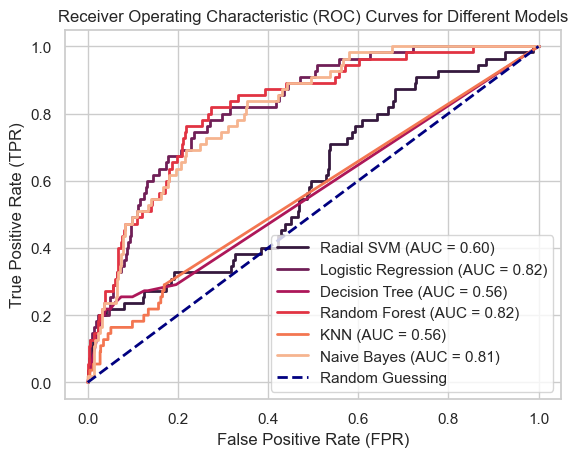

In [15]:
models = [svm, logisticr, dtree, rforest, knn, nb]
labels = ['Radial SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes']

help_tool.plot_roc_curve_many(models, labels, X_validation, y_validation)

## Cross Validation
Cross Validation is performed on all non-tuned models. Weights are used for Validation data.

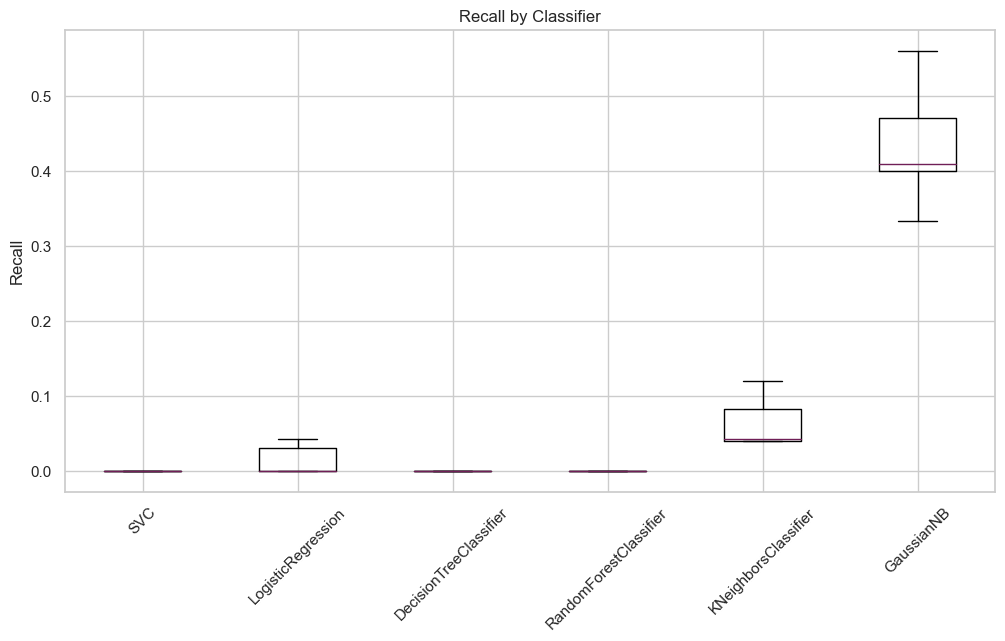

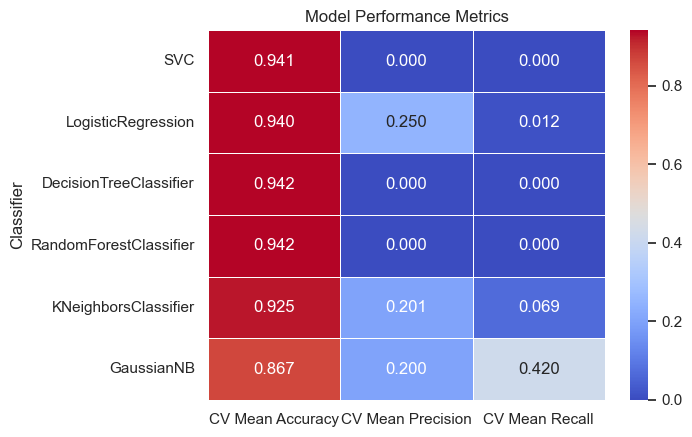

In [16]:
classifiers = [
    SVC(kernel='rbf', C= 0.5116000741838009, gamma= 3.574762761125906), 
    LogisticRegression(C= 21.974951818627517), 
    DecisionTreeClassifier(max_depth= 1), 
    RandomForestClassifier(n_estimators= 10, max_depth= 4), 
    KNeighborsClassifier(weights= 'distance', p= 2, n_neighbors= 3),
    GaussianNB(var_smoothing= 1e-09)
]

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


help_tool.cross_validation_plots(classifiers, 10, X, y, 'Recall')

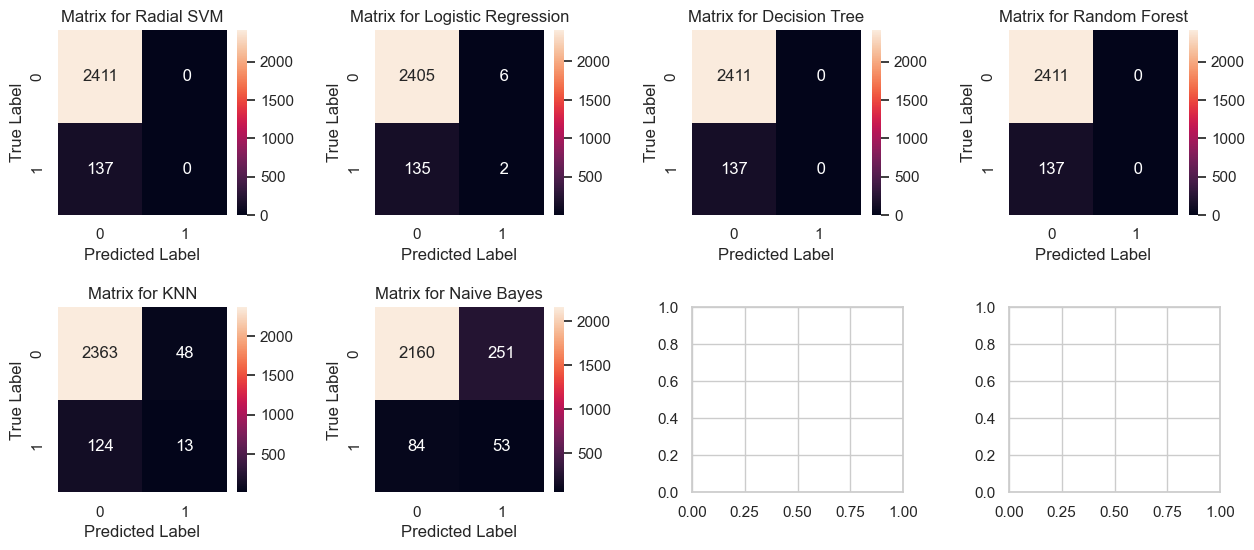

In [17]:
classifier_names = [
    'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes'
]

help_tool.cross_validation_matrix(classifiers, classifier_names, X_train, y_train)

## Oversampling

In [18]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [19]:
y_train_resampled.value_counts()

0    2411
1    2411
Name: Stroke, dtype: int64

In [20]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train_resampled, y_train_resampled)

help_tool.model_selection_recall(dummy, X_train_resampled, y_train_resampled, X_validation, y_validation)

Train Recall: 50.83%
Validation Recall: 5.19%
ROC AUC: 0.50


In [21]:
models = {
    'svm': (SVC(kernel='rbf'), {'svm__C': reciprocal(0.1, 100), 'svm__gamma': reciprocal(0.01, 10)}),
    'logisticr': (LogisticRegression(max_iter=1000), {'logisticr__C': reciprocal(0.1, 100)}),
    'dtree': (DecisionTreeClassifier(), {'dtree__max_depth': list(range(1, 11))}),
    'rforest': (RandomForestClassifier(), {'rforest__n_estimators': list(range(10, 101, 10)), 'rforest__max_depth': list(range(1, 11))}),
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': list(range(2, 11)), 'knn__weights': ['uniform', 'distance'],'knn__p': [1, 2]}),
    'nb': (GaussianNB(), {'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}),
    'xgb': (XGBClassifier(), {'xgb__max_depth': [3, 5, 7], 'xgb__learning_rate': [0.1, 0.01], 'xgb__n_estimators': [100, 200]})
}


for model_name, (model, param_dist) in models.items():
    my_pipeline = Pipeline(steps=[('scaler', StandardScaler()), (model_name, model)])

    random_search = RandomizedSearchCV(
        estimator=my_pipeline, param_distributions=param_dist, cv=5, scoring='recall', n_iter=min(10, len(param_dist)), n_jobs=-1, random_state=42)

    random_search.fit(X_train_resampled, y_train_resampled)

    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    if model_name == 'svm': 
        svm=best_model
        svm_param=best_params
    elif model_name == 'logisticr': 
        logisticr=best_model
        logisticr_param=best_params
    elif model_name == 'dtree': 
        dtree=best_model
        dtree_param=best_params
    elif model_name == 'rforest': 
        rforest=best_model
        rforest_param=best_params
    elif model_name == 'knn': 
        knn=best_model
        knn_param=best_params
    elif model_name == 'nb': 
        nb=best_model
        nb_param=best_params
    elif model_name == 'xgb': 
        xgb=best_model
        xgb_param=best_params

    print(f'--- Best Parameters for {model_name}')         
    help_tool.model_selection_recall(best_model, X_train_resampled, y_train_resampled, X_validation, y_validation)

--- Best Parameters for svm
Train Recall: 95.44%
Validation Recall: 8.26%
ROC AUC: 0.61
--- Best Parameters for logisticr
Train Recall: 75.05%
Validation Recall: 14.39%
ROC AUC: 0.80
--- Best Parameters for dtree
Train Recall: 81.46%
Validation Recall: 10.99%
ROC AUC: 0.66
--- Best Parameters for rforest
Train Recall: 87.03%
Validation Recall: 12.32%
ROC AUC: 0.73
--- Best Parameters for knn
Train Recall: 100.00%
Validation Recall: 8.37%
ROC AUC: 0.60
--- Best Parameters for nb
Train Recall: 71.97%
Validation Recall: 15.52%
ROC AUC: 0.81
--- Best Parameters for xgb
Train Recall: 82.39%
Validation Recall: 13.39%
ROC AUC: 0.72


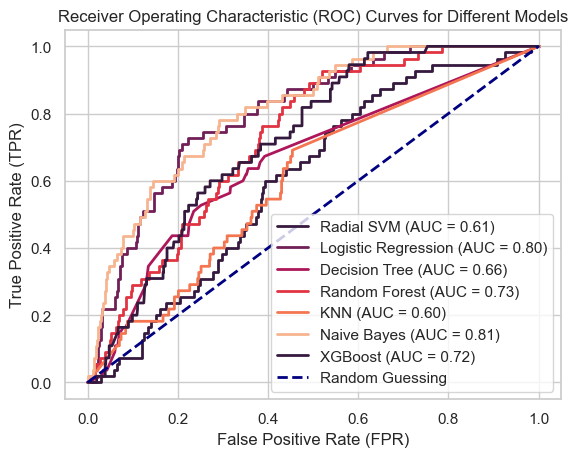

In [22]:
models = [svm, logisticr, dtree, rforest, knn, nb, xgb]
labels = ['Radial SVM', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost']

help_tool.plot_roc_curve_many(models, labels, X_validation, y_validation)

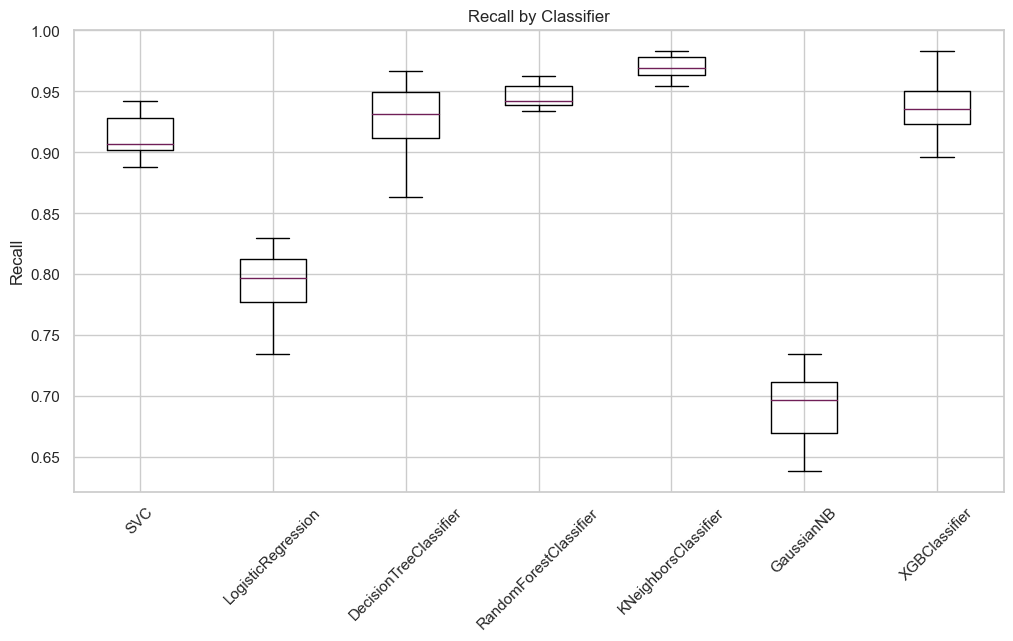

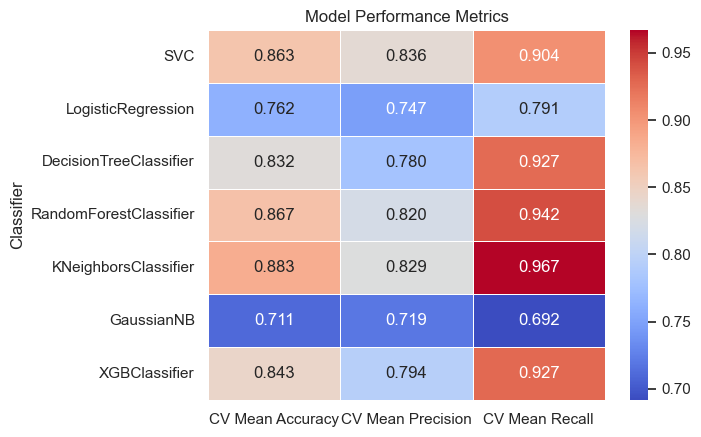

In [23]:
classifiers = [
    SVC(kernel='rbf', C= svm_param['svm__C'], gamma= svm_param['svm__gamma']), 
    LogisticRegression(C= logisticr_param['logisticr__C']), 
    DecisionTreeClassifier(max_depth= dtree_param['dtree__max_depth']), 
    RandomForestClassifier(n_estimators= rforest_param['rforest__n_estimators'], max_depth= rforest_param['rforest__max_depth']), 
    KNeighborsClassifier(weights= knn_param['knn__weights'], p= knn_param['knn__p'], n_neighbors= knn_param['knn__n_neighbors']),
    GaussianNB(var_smoothing= nb_param['nb__var_smoothing']),
    XGBClassifier(max_depth=xgb_param['xgb__max_depth'], learning_rate=xgb_param['xgb__learning_rate'], n_estimators=xgb_param['xgb__n_estimators'])
]


help_tool.cross_validation_plots(classifiers, 10, X_train_resampled, y_train_resampled, 'Recall')

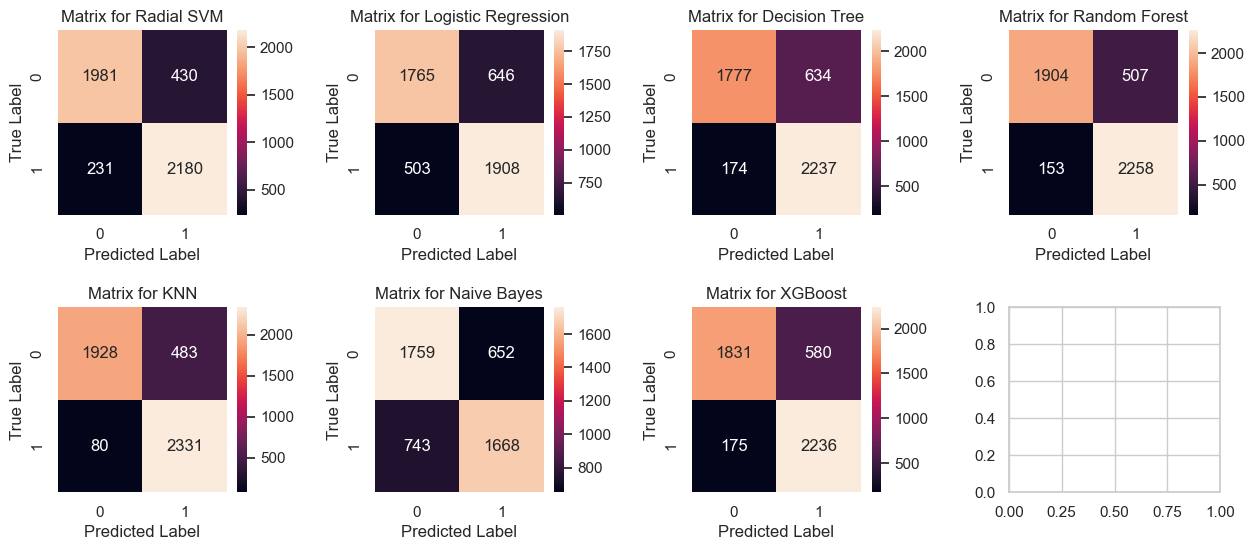

In [24]:
classifier_names = [
    'Radial SVM', 'Logistic Regression',
    'Decision Tree', 'Random Forest', 'KNN', 'Naive Bayes', 'XGBoost'
]

help_tool.cross_validation_matrix(classifiers, classifier_names, X_train_resampled, y_train_resampled)

In [25]:
knn = KNeighborsClassifier(weights= knn_param['knn__weights'], p= knn_param['knn__p'], n_neighbors= knn_param['knn__n_neighbors'])
knn.fit(X_train_resampled, y_train_resampled)

help_tool.model_selection_recall(knn, X_train_resampled, y_train_resampled, X_validation, y_validation)

Train Recall: 100.00%
Validation Recall: 6.60%
ROC AUC: 0.54


# Model interpretation

In [26]:
from lime import lime_tabular
import lime

In [27]:
import lime
from lime.lime_tabular import LimeTabularExplainer

knn = KNeighborsClassifier(weights=knn_param['knn__weights'], p=knn_param['knn__p'], n_neighbors=knn_param['knn__n_neighbors'])
knn.fit(X_train_resampled, y_train_resampled)

explainer = LimeTabularExplainer(X_train_resampled.values, 
                                 feature_names=X_train_resampled.columns, 
                                 class_names=[0, 1])

exp = explainer.explain_instance(X_train_resampled.iloc[-1].values, 
                                 knn.predict_proba,
                                 num_features=len(X_train_resampled.columns))


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


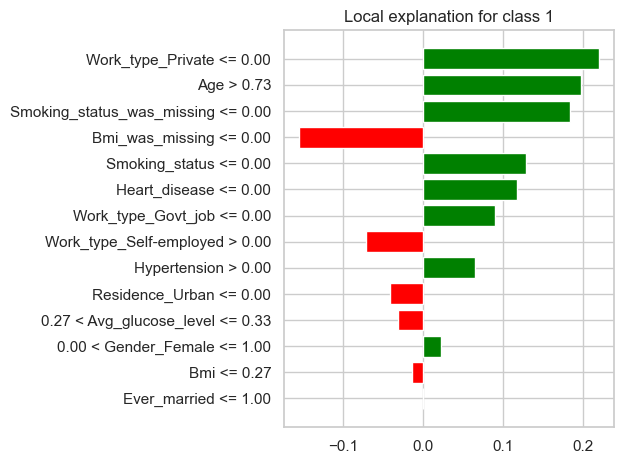

In [28]:
fig = exp.as_pyplot_figure()
fig.tight_layout()

In [31]:
target_idx=1

In [35]:
# Summarize the background data using shap.sample
background_samples = shap.sample(X_train_resampled, 100)  # Adjust the number of samples as needed

# Calculate SHAP values using KernelExplainer
explainer = shap.KernelExplainer(knn.predict_proba, background_samples)
shap_vals = explainer.shap_values(X_train_resampled.iloc[target_idx])

# Visualize the explanation for the specified target index
if len(shap_vals) == 1:
    shap.force_plot(explainer.expected_value[0], shap_vals[0], features=X_train_resampled.iloc[target_idx], feature_names=X_train_resampled.columns)
else:
    print("Error: Unexpected number of SHAP values arrays.")

Error: Unexpected number of SHAP values arrays.


# Permutations

In [38]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(knn, random_state=42).fit(X_validation, y_validation)
eli5.show_weights(perm, feature_names = X_validation.columns.tolist())

Weight,Feature
0.0600 ± 0.0154,Work_type_Private
0.0440 ± 0.0057,Work_type_Govt_job
0.0336 ± 0.0078,Work_type_Self-employed
0.0275 ± 0.0168,Age
0.0016 ± 0.0048,Bmi_was_missing
-0.0002 ± 0.0050,Bmi
-0.0009 ± 0.0040,Heart_disease
-0.0014 ± 0.0281,Residence_Urban
-0.0016 ± 0.0122,Avg_glucose_level
-0.0019 ± 0.0104,Hypertension


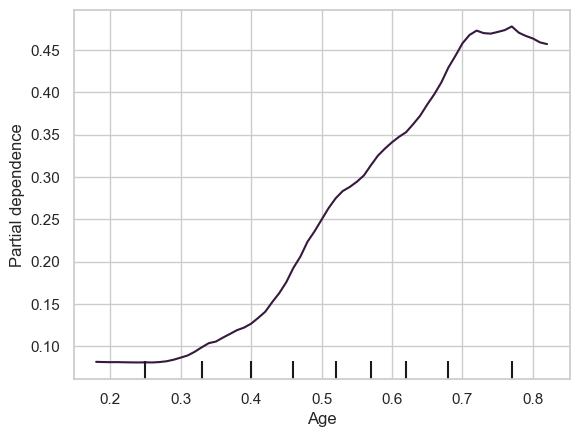

In [40]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(knn, X_validation, ['Age'])
plt.show()

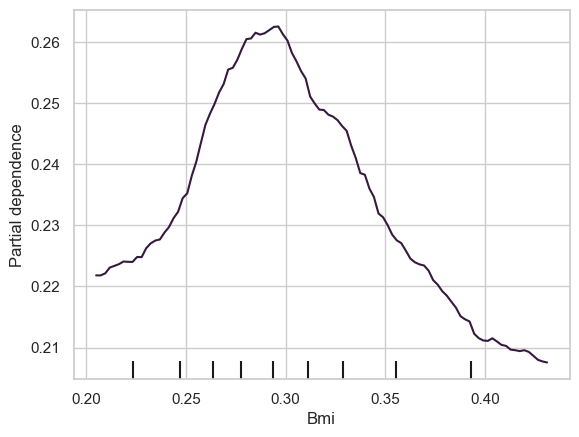

In [42]:
PartialDependenceDisplay.from_estimator(knn, X_validation, ['Bmi'])
plt.show()

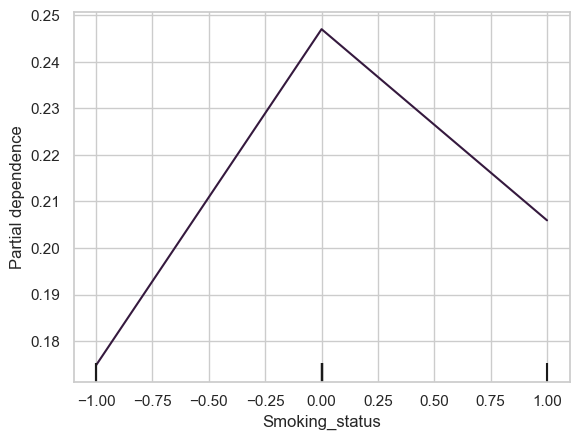

In [43]:
PartialDependenceDisplay.from_estimator(knn, X_validation, ['Smoking_status'])
plt.show()